In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from itertools import product
from functools import partial
from multiprocessing import Pool, cpu_count
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import warnings
warnings.filterwarnings('ignore')

from CI import compute_V

In [2]:
df = pd.read_table('spambase.data', sep = ',', header = None).values
X = df[:, :-1]
y = df[:, -1]
n = df.shape[0]
train_size = 3065
test_size = n - train_size

In [33]:
def figure_4(max_features, random_seed):
    np.random.seed(random_seed)
    train_indice = np.random.choice(range(n), 3065, replace = False)
    test_indice = np.array(list(set(np.arange(n)) - set(train_indice)))
    X_train, y_train, X_test, y_test = X[train_indice], y[train_indice], X[test_indice], y[test_indice]

    # create RandomForestClassifier
    n_trees = 40000
    spam_RFC = RandomForestClassifier(max_features=max_features, n_estimators=n_trees,
                                      random_state=random_seed)
    spam_RFC.fit(X_train, y_train)
    test_prob = spam_RFC.predict_proba(X_test)[:, 1]
    correct_indice = (spam_RFC.predict(X_test)==y_test)
    error_indice = (spam_RFC.predict(X_test)!=y_test)
    V_J, _, _, V_IJ = compute_V(spam_RFC, X_train, X_test)
    return test_prob[correct_indice], test_prob[error_indice], V_IJ[correct_indice], V_IJ[error_indice] 

In [34]:
%%time
n_process = 10
n_parallel = 10
random_seeds = list(range(n_parallel))
max_features = [5, 19, 57]
with Pool(processes = n_process) as pool:
    collection_source = pool.starmap(figure_4, product(max_features, random_seeds))

collection = list()
for i in range(len(max_features)):
    collection.append(list())
    for j in range(n_parallel):
        collection[i].append(collection_source[i*len(max_features)+j])

CPU times: user 2.05 s, sys: 867 ms, total: 2.91 s
Wall time: 40min 5s


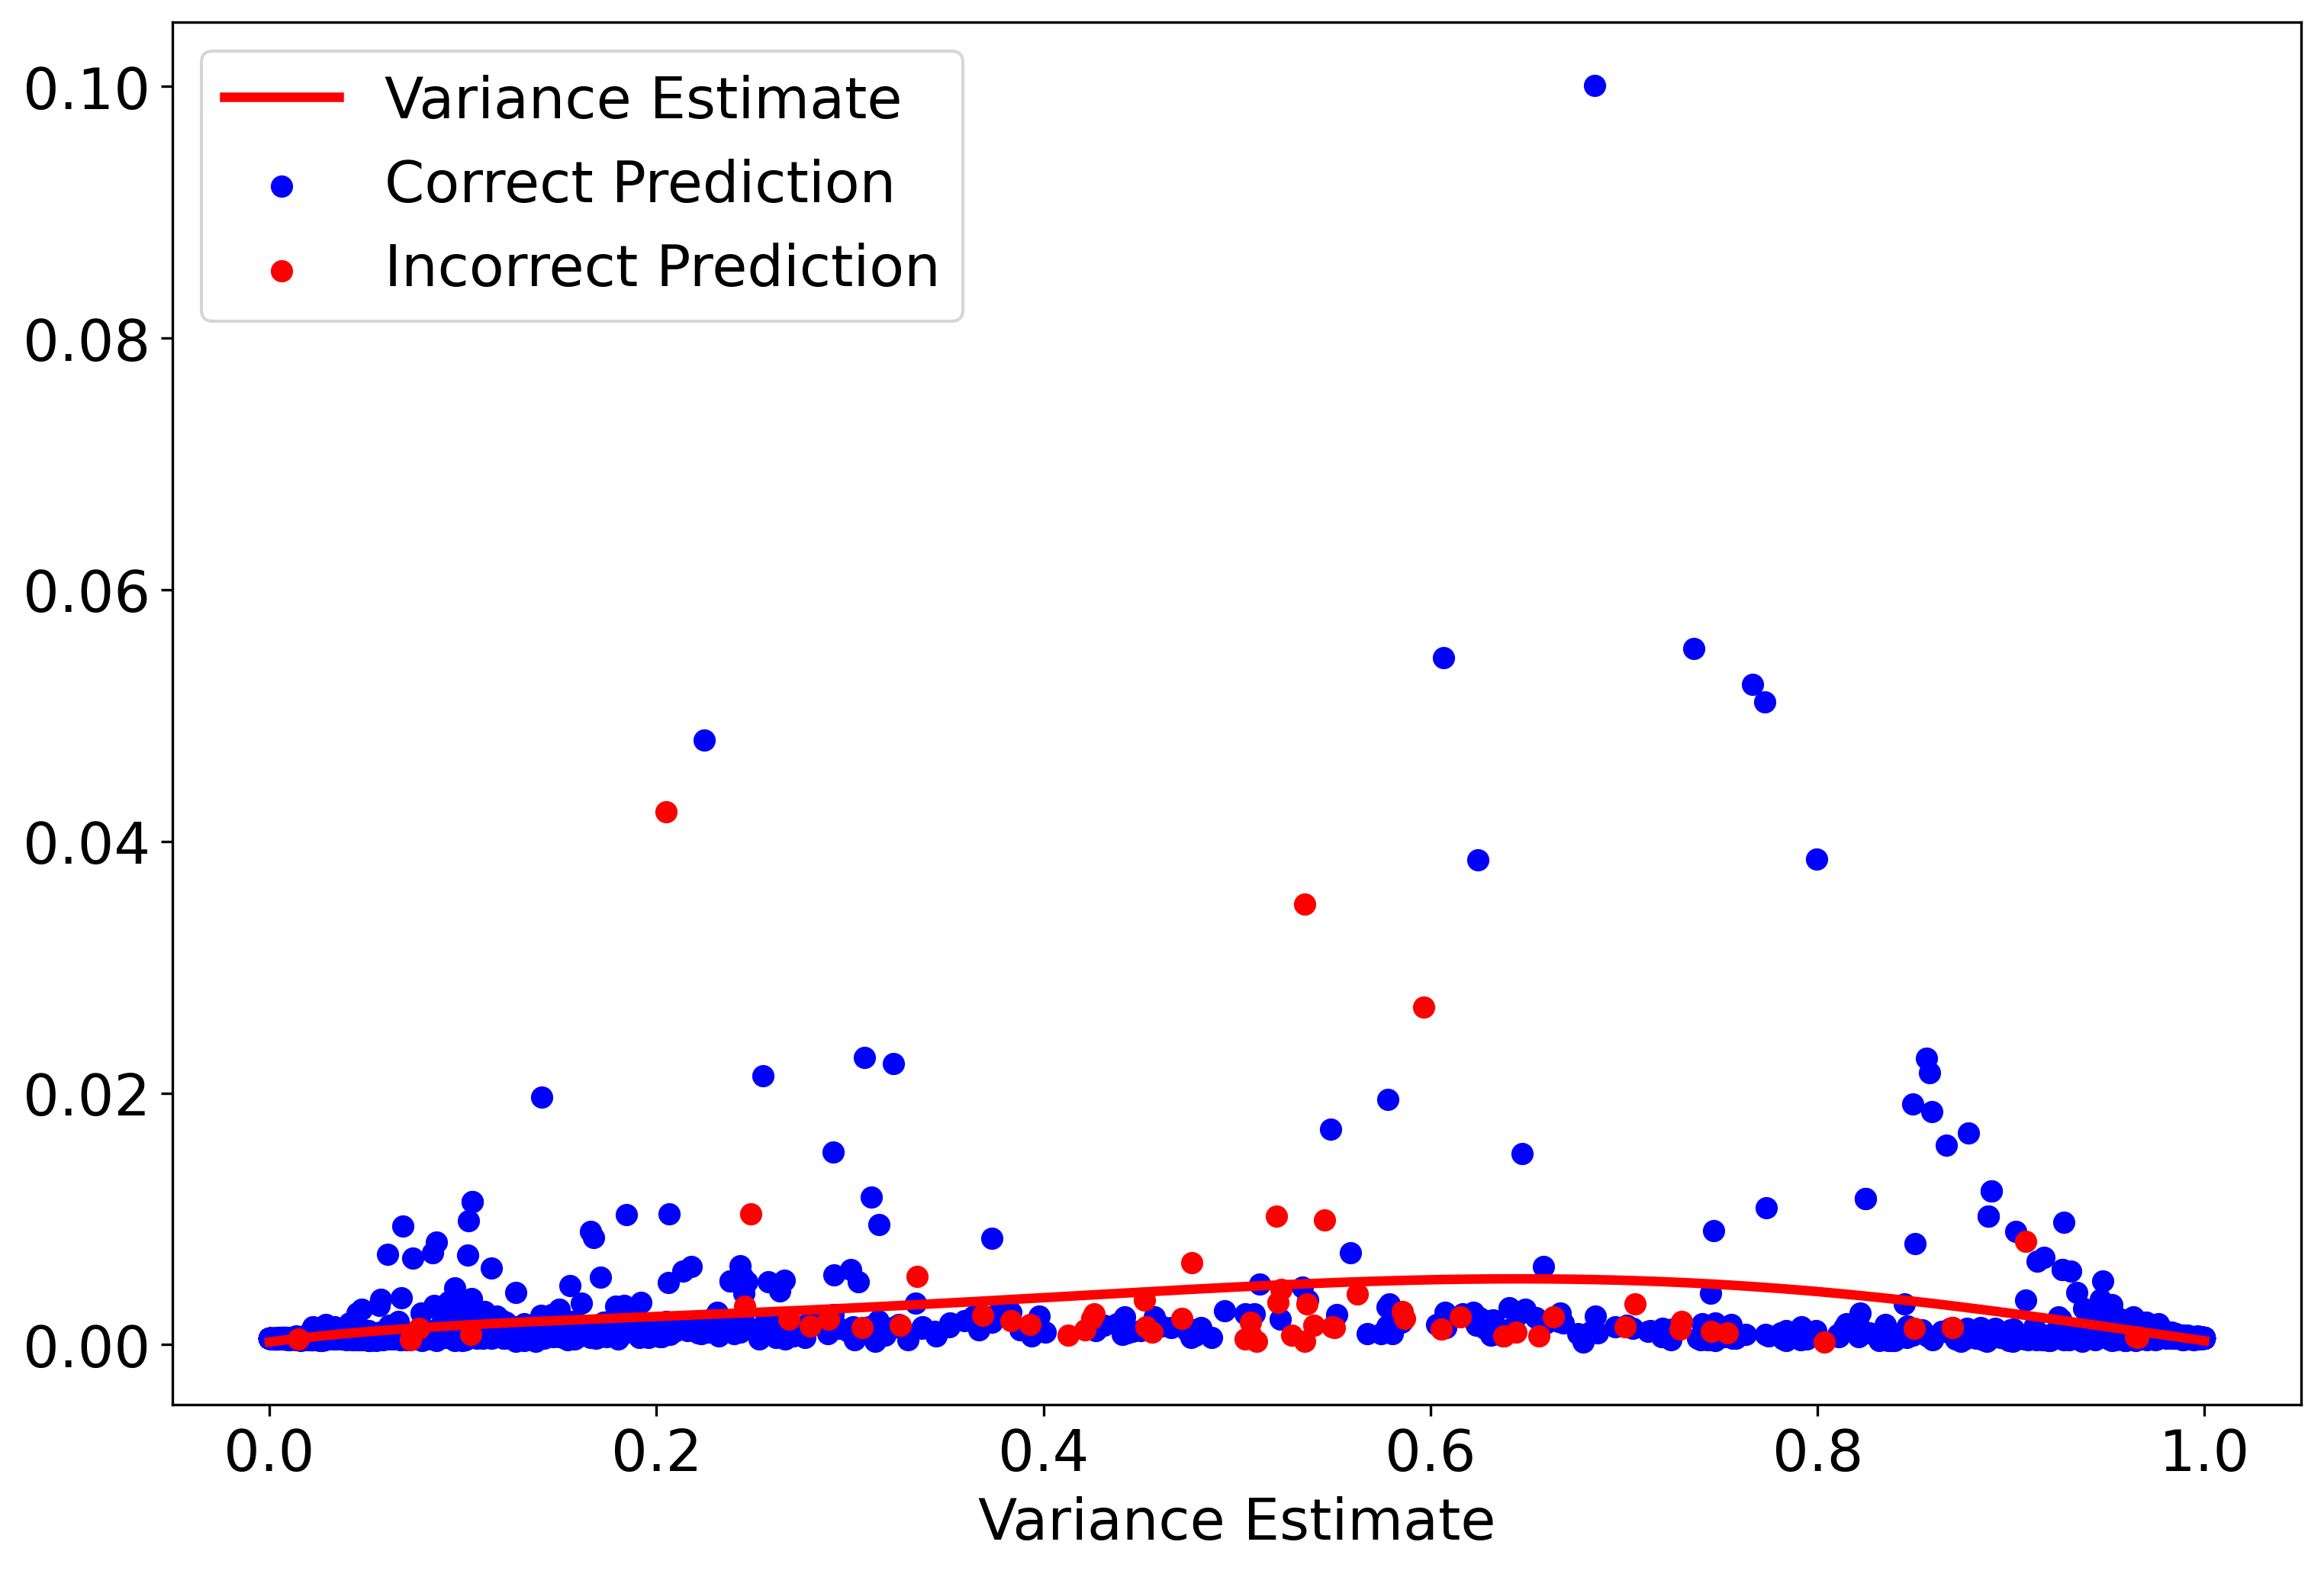

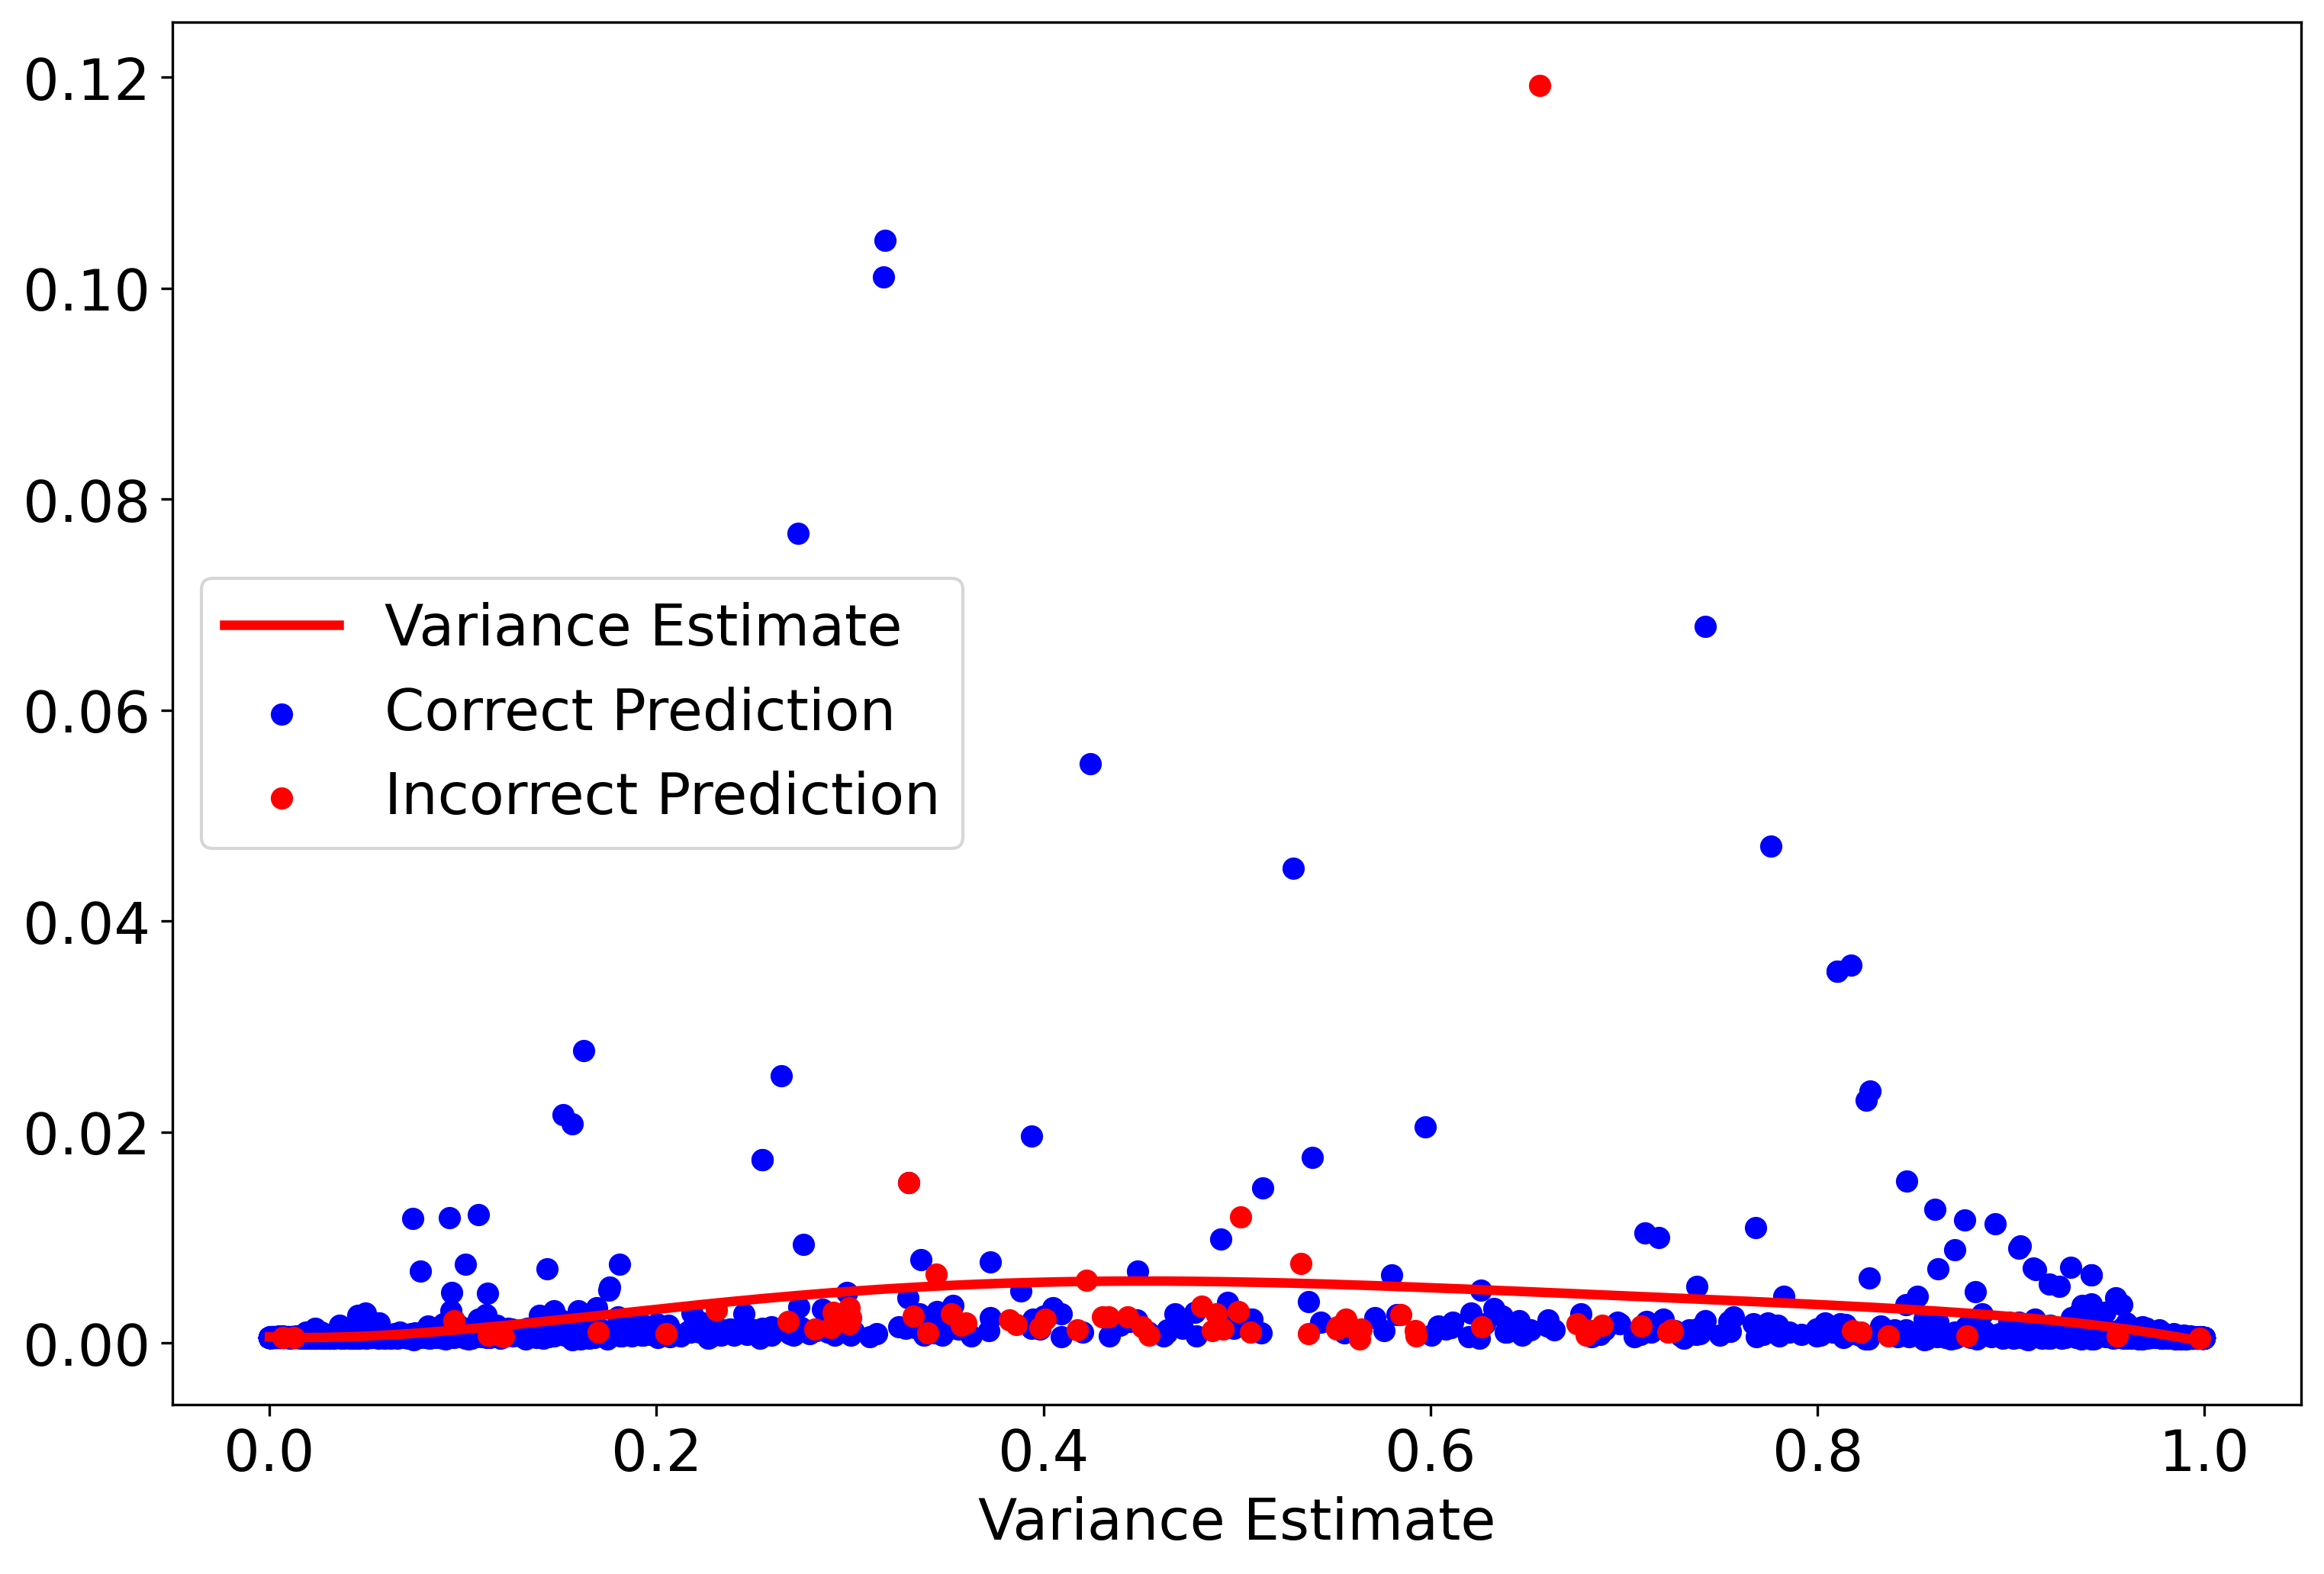

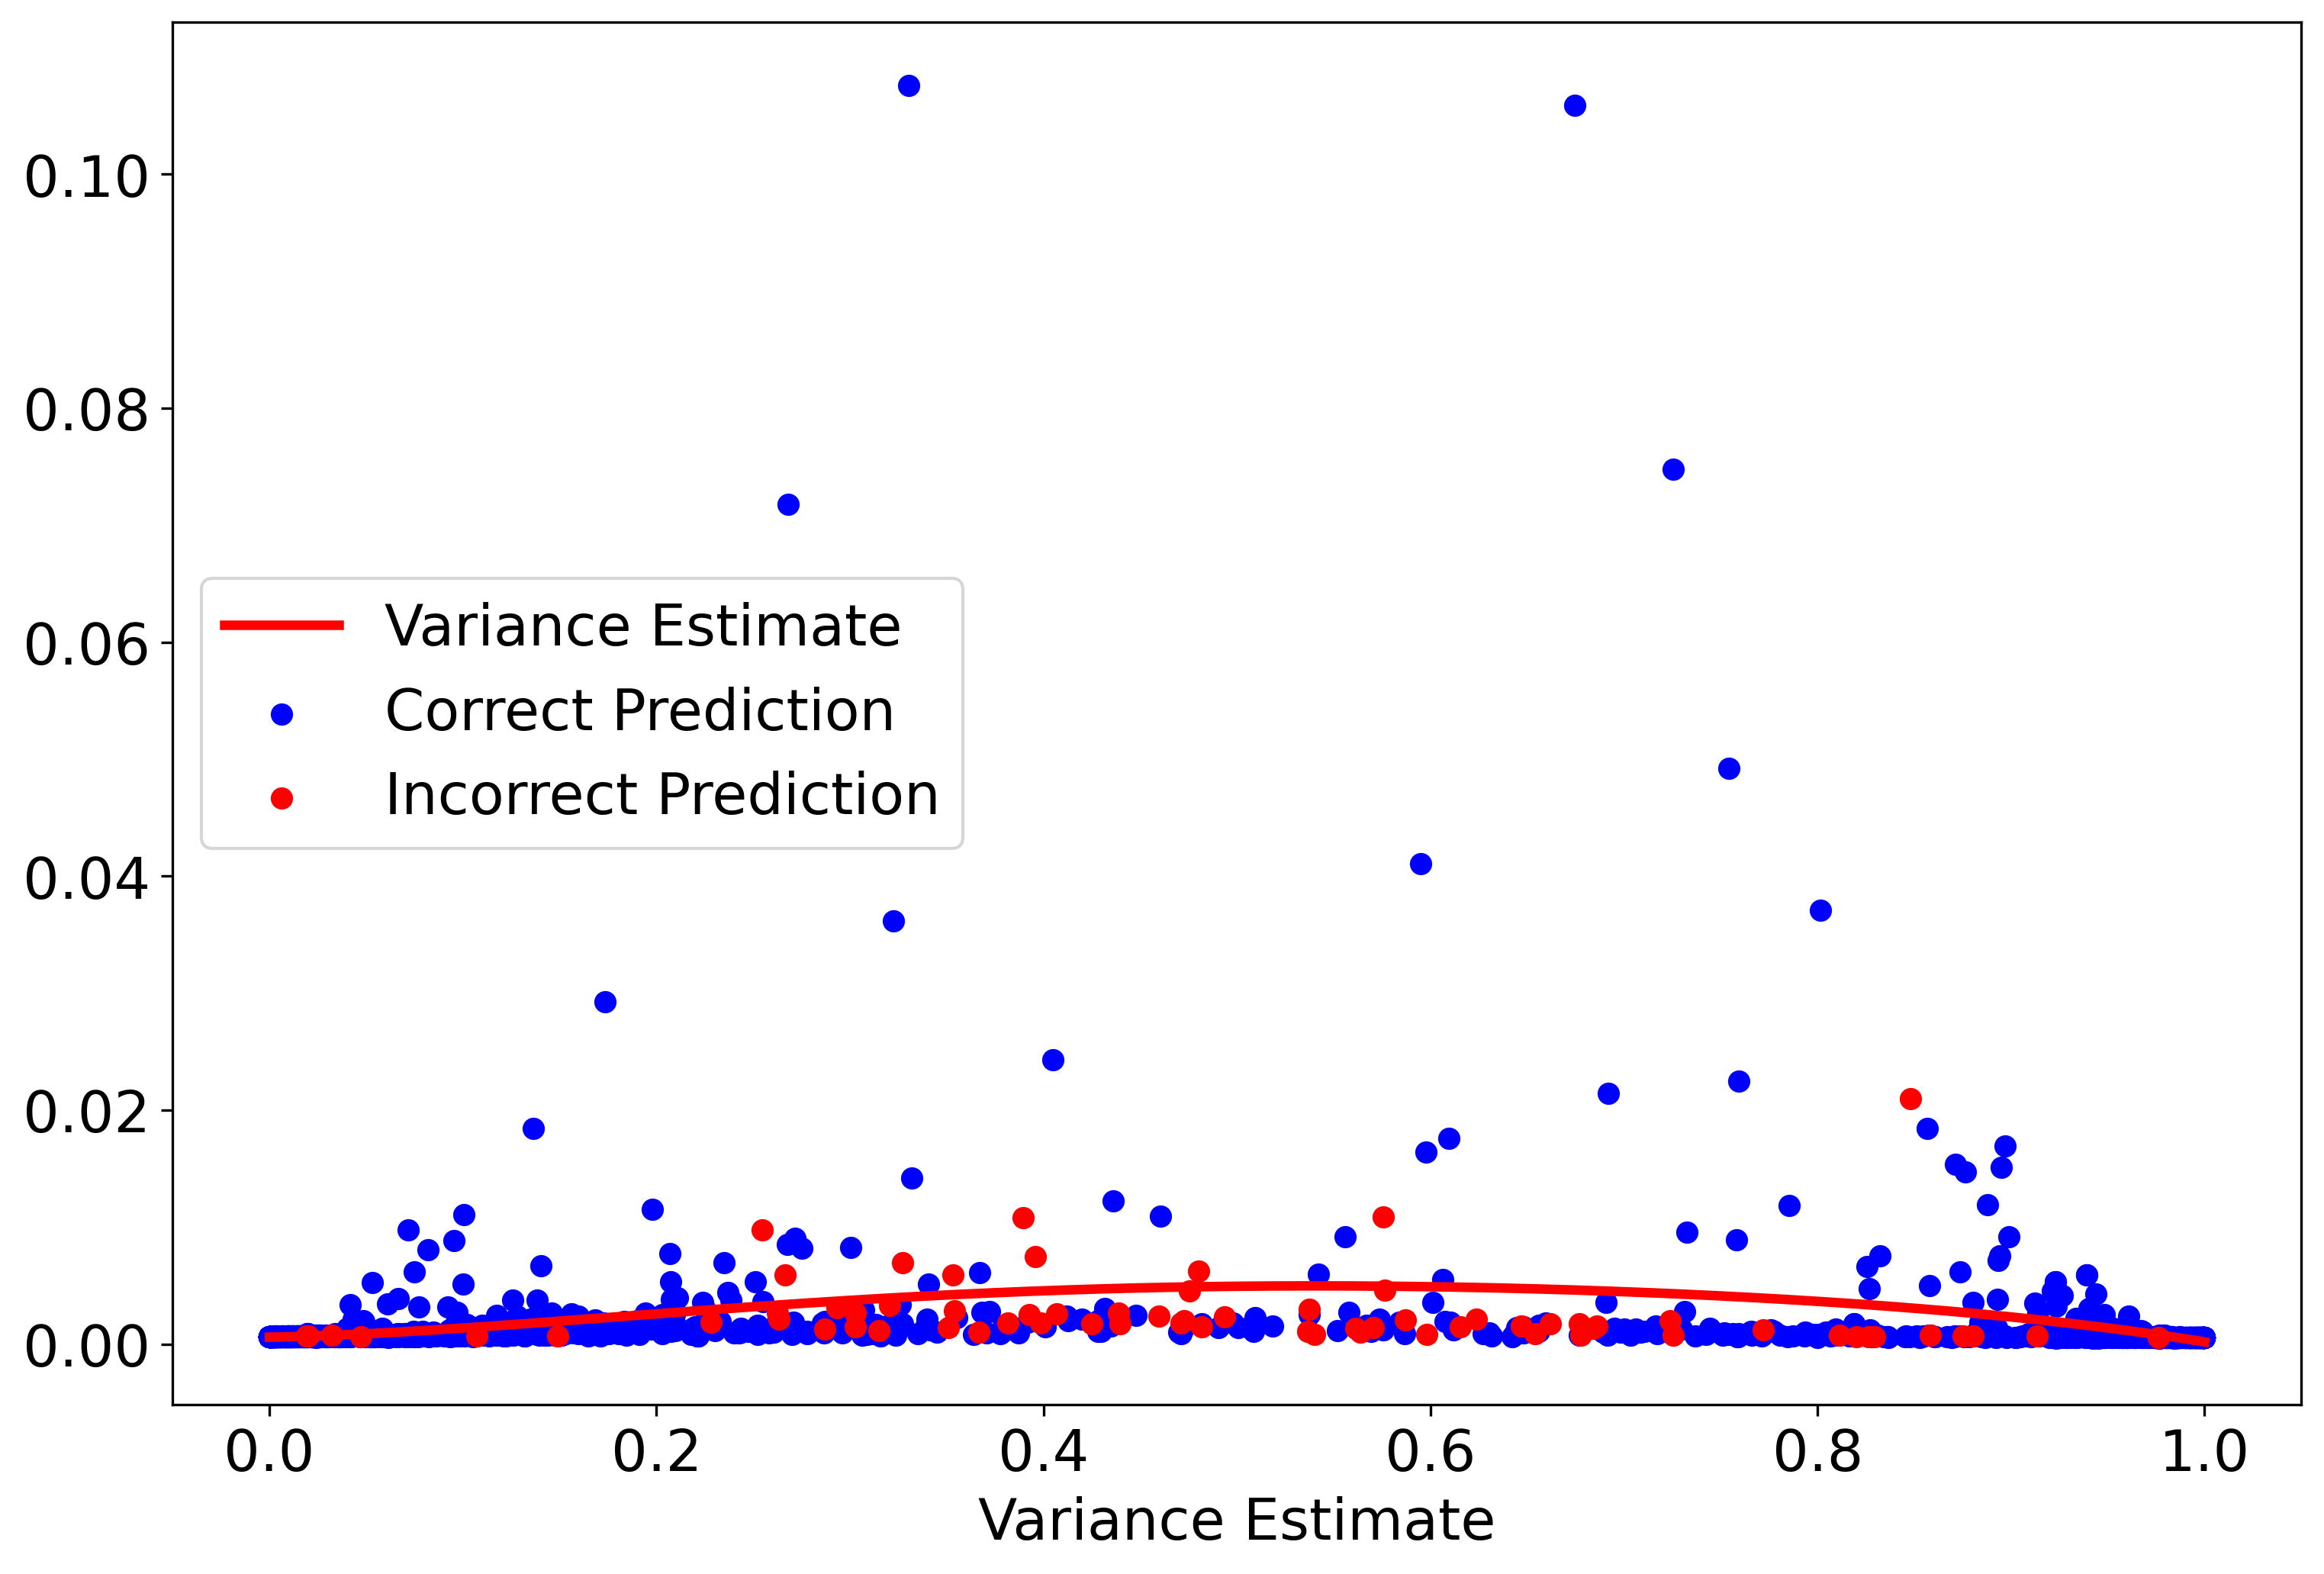

In [41]:
for i, max_feature in enumerate(max_features): 
    fig, axes = plt.subplots(figsize = (12, 8), nrows=1, ncols=1, dpi = 300)
    test_prob_correct, test_prob_error, V_IJ_correct, V_IJ_error = collection[i][0]
    axes.scatter(test_prob_correct, V_IJ_correct, color = 'b', label = 'Correct Prediction')
    axes.scatter(test_prob_error, V_IJ_error, color = 'r', label = 'Incorrect Prediction')
    indice = np.argsort(np.concatenate([test_prob_correct, test_prob_error]))
    test_prob = np.concatenate([test_prob_correct, test_prob_error])[indice]
    V_IJ = np.concatenate([V_IJ_correct, V_IJ_error])[indice]
    spl = scipy.interpolate.UnivariateSpline(test_prob, V_IJ, k =5)
    xs = np.linspace(0, 1, 1000)
    axes.plot(xs, spl(xs), color = 'red', linewidth = 3, label = 'Variance Estimate')
    plt.xlabel('Prediction')
    plt.xlabel('Variance Estimate')
    plt.legend()
    plt.savefig('../figures/figure4(1)' + str(i) + '.pdf', dpi = 300)
plt.show()

### Figure 5

In [13]:
import scipy

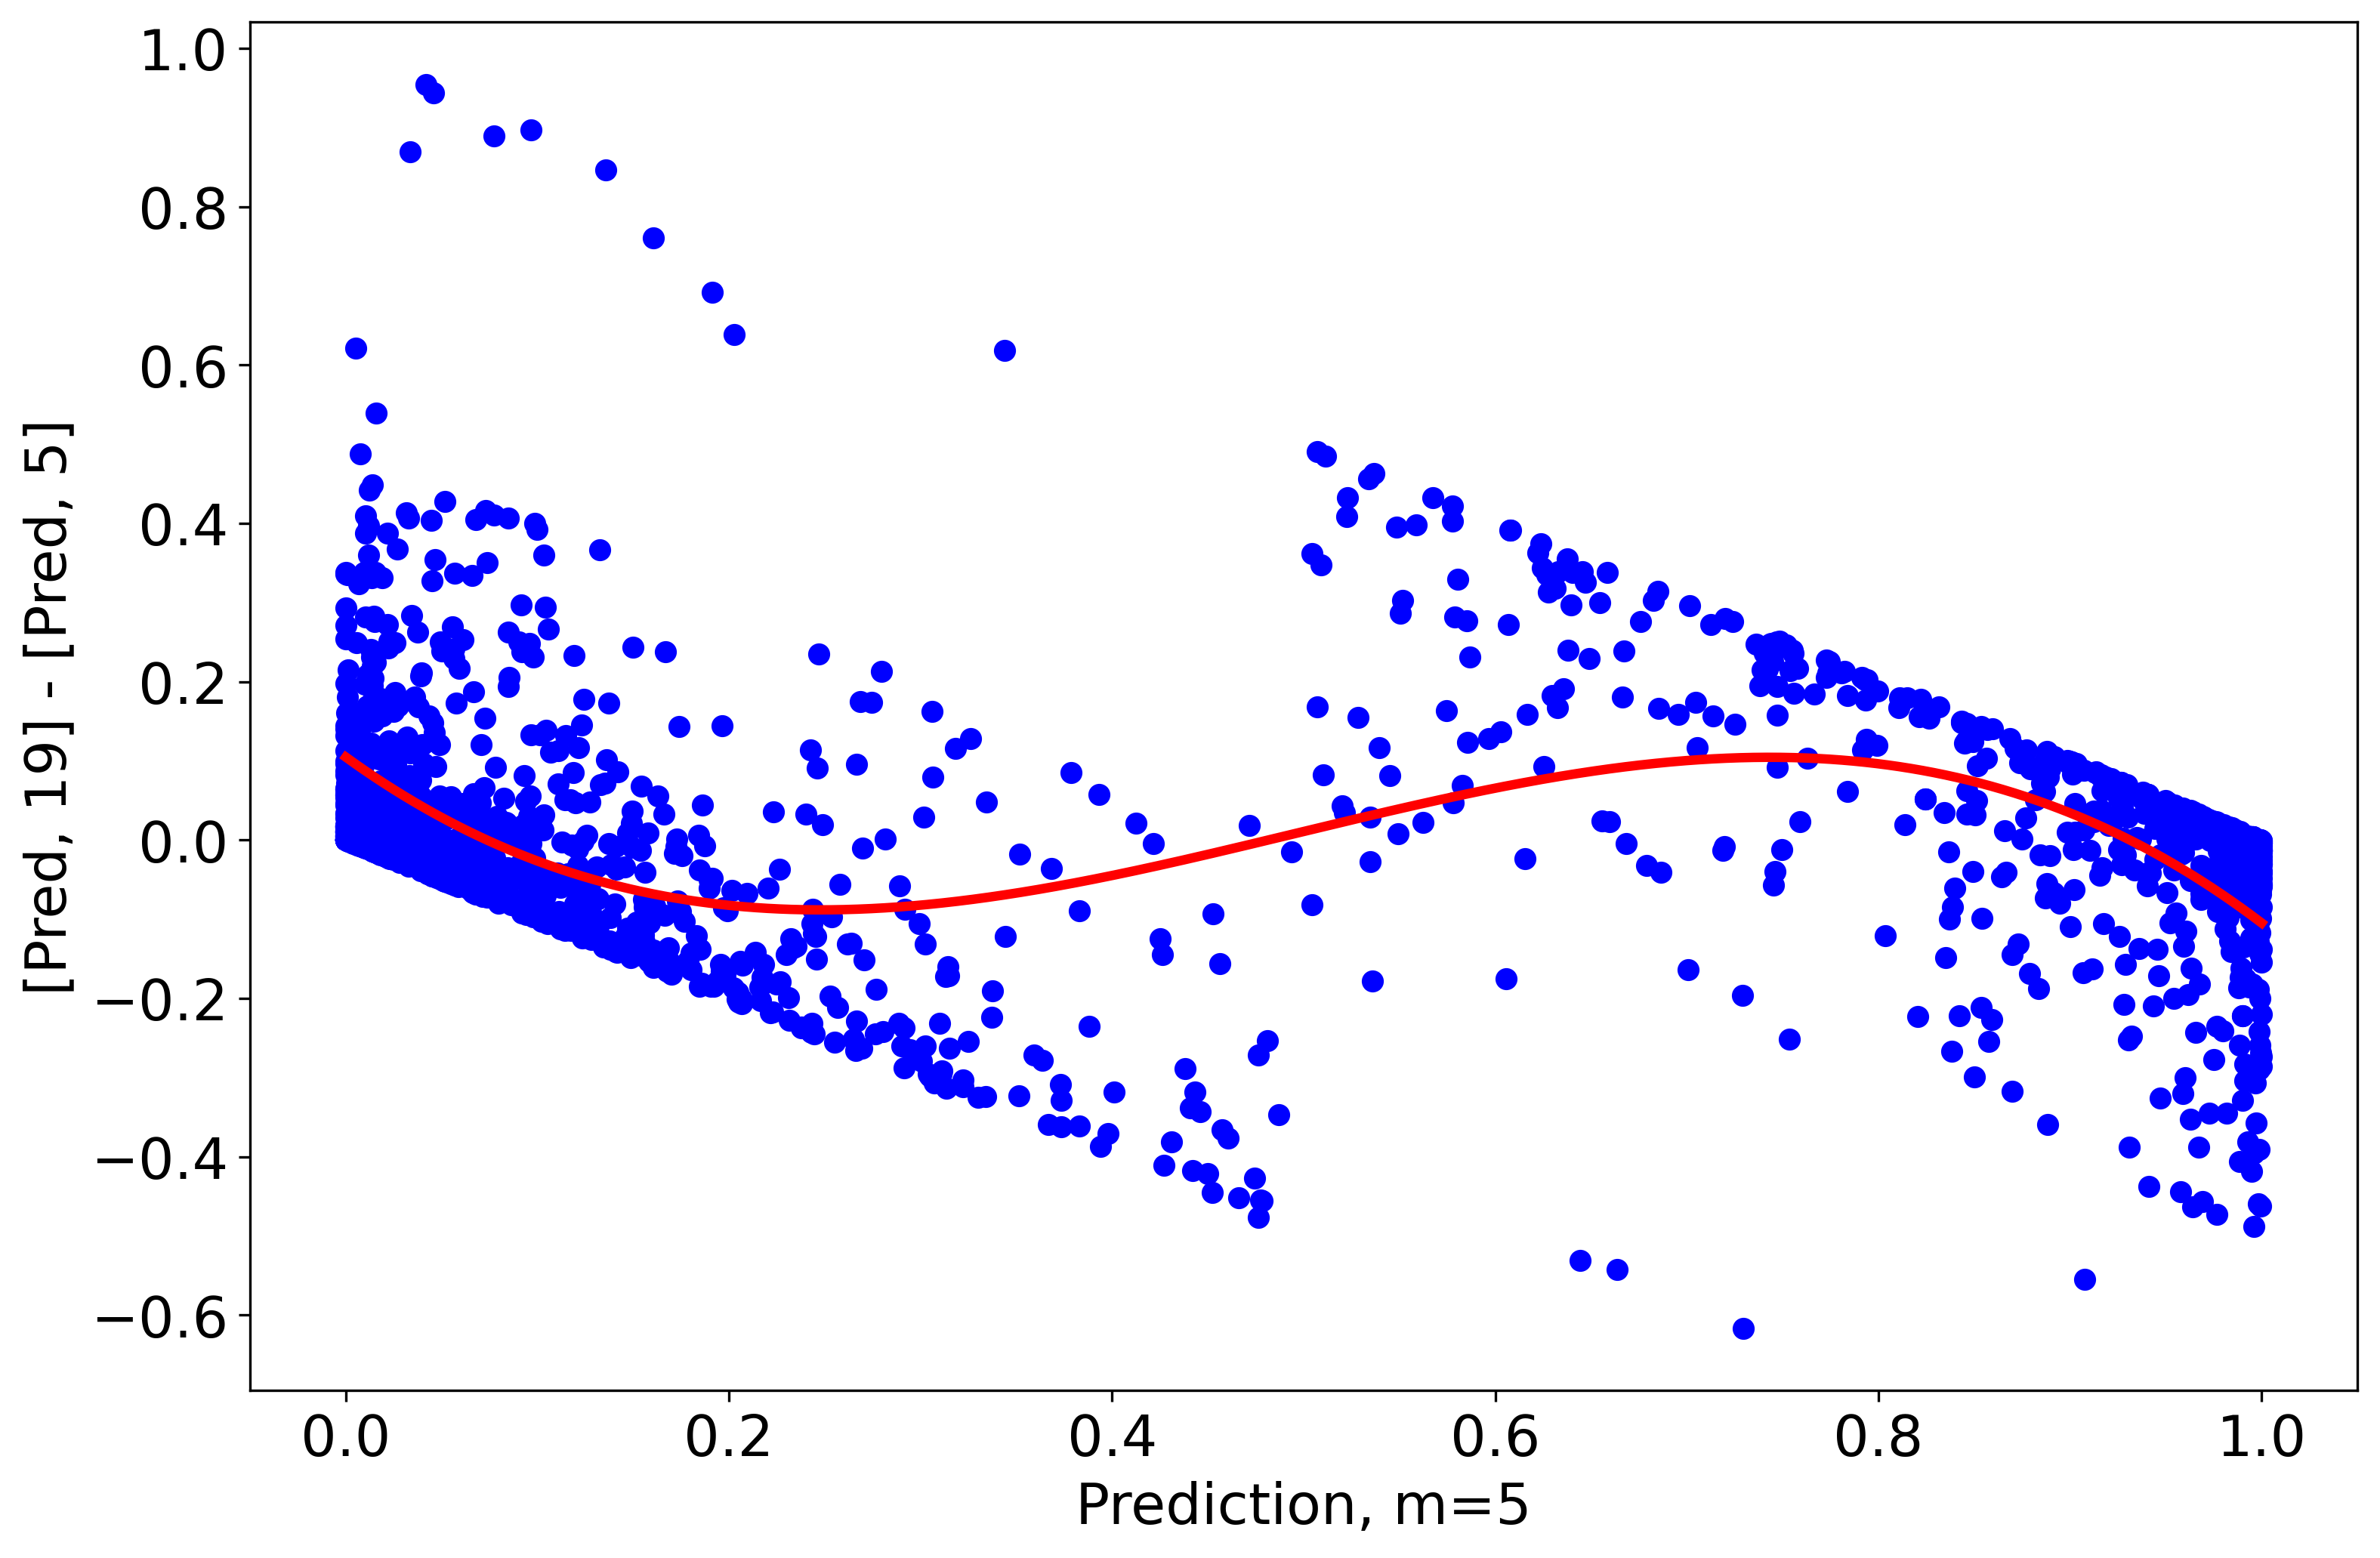

In [37]:
fig, axes = plt.subplots(figsize = (12, 8), nrows=1, ncols=1, dpi = 300)
test_prob_correct_5, test_prob_error_5, V_IJ_correct_5, V_IJ_error_5 = collection[0][0]
test_prob_5 = np.concatenate([test_prob_correct_5, test_prob_error_5])
V_J_5 = np.concatenate([ V_IJ_correct_5,  V_IJ_error_5])

test_prob_correct_19, test_prob_error_19,  V_IJ_correct_19,  V_IJ_error_19 = collection[1][0]
test_prob_19 = np.concatenate([test_prob_correct_19, test_prob_error_19])
V_J_19 = np.concatenate([ V_IJ_correct_19,  V_IJ_error_19])

indice_5 = np.argsort(test_prob_5)
axes.scatter(test_prob_5[indice_5], test_prob_19[indice_5] - test_prob_5[indice_5], color = 'b')

spl = scipy.interpolate.UnivariateSpline(test_prob_5[indice_5], test_prob_19[indice_5] - test_prob_5[indice_5], k =3)
xs = np.linspace(0, 1, 1000)
axes.plot(xs, spl(xs), color = 'red', linewidth = 3)
plt.xlabel('Prediction, m=5')
plt.ylabel('[Pred, 19] - [Pred, 5]')
plt.savefig('../figures/figure4(2).pdf', dpi = 300)
plt.show()